<font size=6>In this file, three data processing will be tested:
- 1. Full dataset (training + test dataset)
- 2. Splitting training dataset into a new train one and a new test one (SMOTE and random undersampling)
- 3. Not removing the Null column and try filling with some random values then 2.

Initialisation + Metrics

In [187]:
import numpy as np
import pandas as pd
import imblearn as imb
import matplotlib.pyplot as plt
from collections import Counter
import sklearn as skl
from sklearn.naive_bayes import GaussianNB
import sklearn.metrics as met
import plotly.express as px
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.svm import OneClassSVM
import random as rd
from sklearn.ensemble import IsolationForest,RandomForestClassifier

In [188]:
def many_Metrics(y_test,y_pred):
  A = met.confusion_matrix(y_test,y_pred)
  print("Confusion Matrix: {}".format(A))
  print("Surface under the ROC AUC Curve: {}".format(met.roc_auc_score(y_test,y_pred)))
  print("Accuracy: {}".format(met.accuracy_score(y_test,y_pred)))
  print("Precision: {}".format(A[0,0]/(A[0,0]+A[0,1])))
  print("Recall: {}".format(met.recall_score(y_test,y_pred)))
  fpr,tpr,thresholds = met.roc_curve(y_test, y_pred)
  plt.figure(figsize=(15,15))
  plt.plot([0, 1], [0, 1], "k--")
  plt.plot(fpr,tpr)
  return met.roc_auc_score(y_test,y_pred)

In [189]:
input_header = {"PROC_TRACEINFO" : "id",
                "OP070_V_1_angle_value": "angle_1",
                "OP090_SnapRingPeakForce_value" : "snap_ring_peak_force",
                "OP070_V_2_angle_value" : "angle_2",
                "OP120_Rodage_I_mesure_value" : "rodage_i",
                "OP090_SnapRingFinalStroke_value" : "snap_ring_final_stroke",
                "OP110_Vissage_M8_torque_value" : "vissage_m8_torque",
                "OP100_Capuchon_insertion_mesure" : "capuchon_insertion",
                "OP120_Rodage_U_mesure_value" : "rodage_u",
                "OP070_V_1_torque_value" : "torque_1",
                "OP090_StartLinePeakForce_value" : "start_line_peak_force",
                "OP110_Vissage_M8_angle_value" : "vissage_m8_angle",
                "OP090_SnapRingMidPointForce_val" : "snap_ring_midpoint_force",
                "OP070_V_2_torque_value" : "torque_2"}
output_header = {"PROC_TRACEINFO" : "id",
                 "Binar OP130_Resultat_Global_v" : "result"}

<font size=5> Full Dataset 

Ne fonctionne pas du tout, peut-être erreur d'inattention

In [190]:
train_input = pd.read_csv("train_inputs.csv", header=0).rename(columns=input_header)
train_output = pd.read_csv("train_output.csv", header=0).rename(columns=output_header)

test_input = pd.read_csv("test_inputs.csv", header=0).rename(columns=input_header)
test_output = pd.read_csv("test_output.csv", header=0).rename(columns=output_header)

train_input = train_input[train_input.columns[~train_input.columns.isin([ "capuchon_insertion"])]]
test_input = test_input[test_input.columns[~test_input.columns.isin([ "capuchon_insertion"])]]

XY_df = pd.merge(train_input, train_output, on='id', how='inner')
TRAIN = XY_df.to_numpy()
XYe_df = pd.merge(test_input, test_output, on='id', how='inner')
TEST = XYe_df.to_numpy()

X_train = TRAIN[:,1:-2]
X_test = TEST[:,1:-2]
y_train = TRAIN[:,-1]
y_test = TEST[:,-1]

X_train = X_train.astype('float64')
y_train = y_train.astype('int')
X_test = X_test.astype('float64')
y_test = y_test.astype('int')

oversample = imb.over_sampling.SMOTE()
X_SMOTE, y_SMOTE = oversample.fit_resample(X_train,y_train)

Confusion Matrix: [[1820  461]
 [4544 1176]]
Surface under the ROC AUC Curve: 0.5017450326963698
Accuracy: 0.37445319335083116
Precision: 0.7978956597983341
Recall: 0.2055944055944056


0.5017450326963698

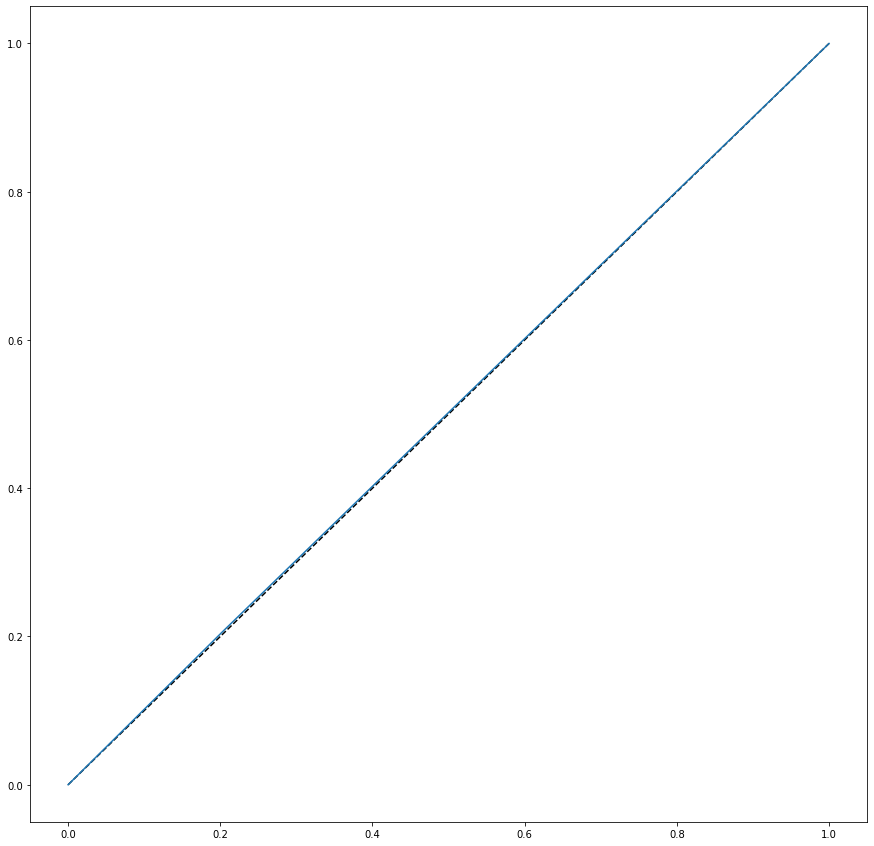

In [191]:
RF = RandomForestClassifier(n_estimators=3000,max_samples=60,max_features=None,random_state=42,n_jobs = -1)
RF.fit(X_SMOTE,y_SMOTE)
y_pred = RF.predict(X_test)

many_Metrics(y_test,y_pred)

<font size=5> 2. Split training dataset into two (NaN column tossed)

a) SMOTE

In [192]:
train_input = pd.read_csv("train_inputs.csv", header=0).rename(columns=input_header)
train_output = pd.read_csv("train_output.csv", header=0).rename(columns=output_header)

train_input = train_input[train_input.columns[~train_input.columns.isin(["id", "capuchon_insertion"])]]
X_train, X_test, y_train, y_test = train_test_split(train_input, train_output["result"], test_size = 0.3, random_state = 123)

In [193]:
oversample = imb.over_sampling.SMOTE()
X_SMOTE, y_SMOTE = oversample.fit_resample(X_train,y_train)

Confusion Matrix: [[8308 1955]
 [  51   41]]
Surface under the ROC AUC Curve: 0.6275810319043928
Accuracy: 0.8062771607918879
Precision: 0.809509889895742
Recall: 0.44565217391304346


0.6275810319043928

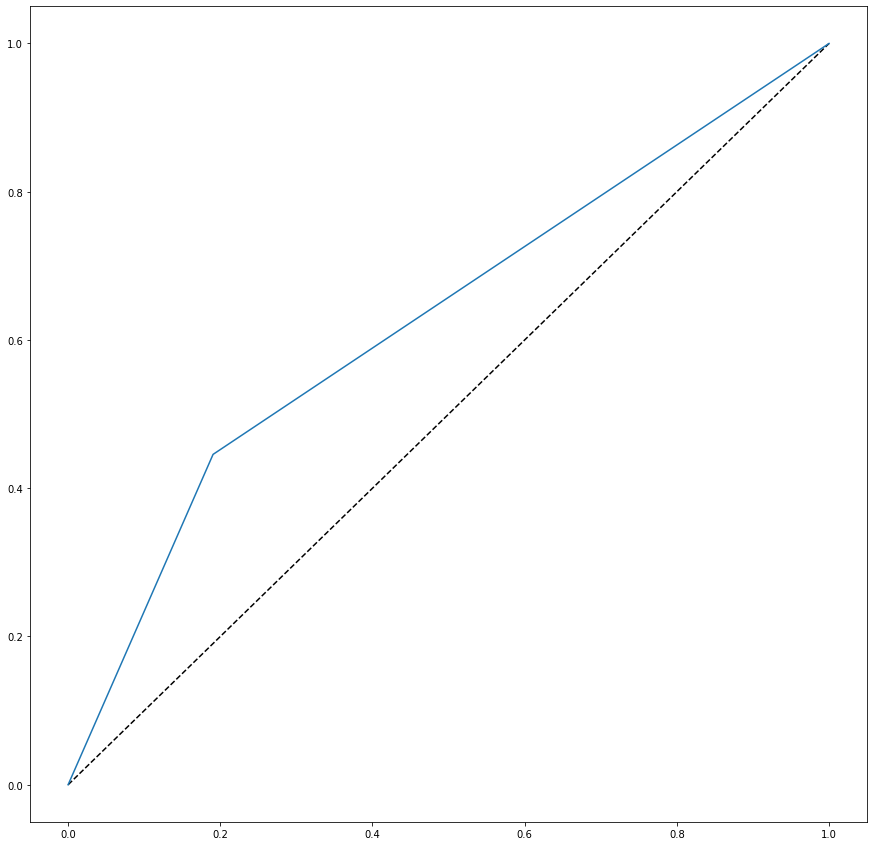

In [194]:
RF = RandomForestClassifier(n_estimators=1000,max_samples=65,max_features=None,random_state=42,n_jobs = -1,oob_score=True)
RF.fit(X_SMOTE,y_SMOTE)
y_pred = RF.predict(X_test)

many_Metrics(y_test,y_pred)

b) Random-under sampling (better recall) 

In [195]:
train_input_remove =  pd.read_csv("train_inputs.csv", header=0).rename(columns=input_header)
train_output_remove = pd.read_csv("train_output.csv", header=0).rename(columns=output_header)

# Select index
defect_index = train_output_remove.index[train_output["result"] == 1].tolist()
valid_index = train_output_remove.index[train_output["result"] == 0].tolist()

# Randomly remove some valid individuals
rd.shuffle(valid_index) # Shuffle in order to eliminate "production correlation"
train_input_remove = train_input_remove.iloc[valid_index[:len(defect_index)] + defect_index,:]
train_output_remove = train_output_remove.iloc[valid_index[:len(defect_index)] + defect_index,:]

# Create new datasets
train_input_remove = train_input_remove[train_input_remove.columns[~train_input_remove.columns.isin(["id", "capuchon_insertion"])]]
X_train, X_test, y_train, y_test = train_test_split(train_input_remove, train_output_remove["result"], test_size = 0.3, random_state = 123)

Confusion Matrix: [[61 31]
 [36 55]]
Surface under the ROC AUC Curve: 0.633719541328237
Accuracy: 0.6338797814207651
Precision: 0.6630434782608695
Recall: 0.6043956043956044


0.633719541328237

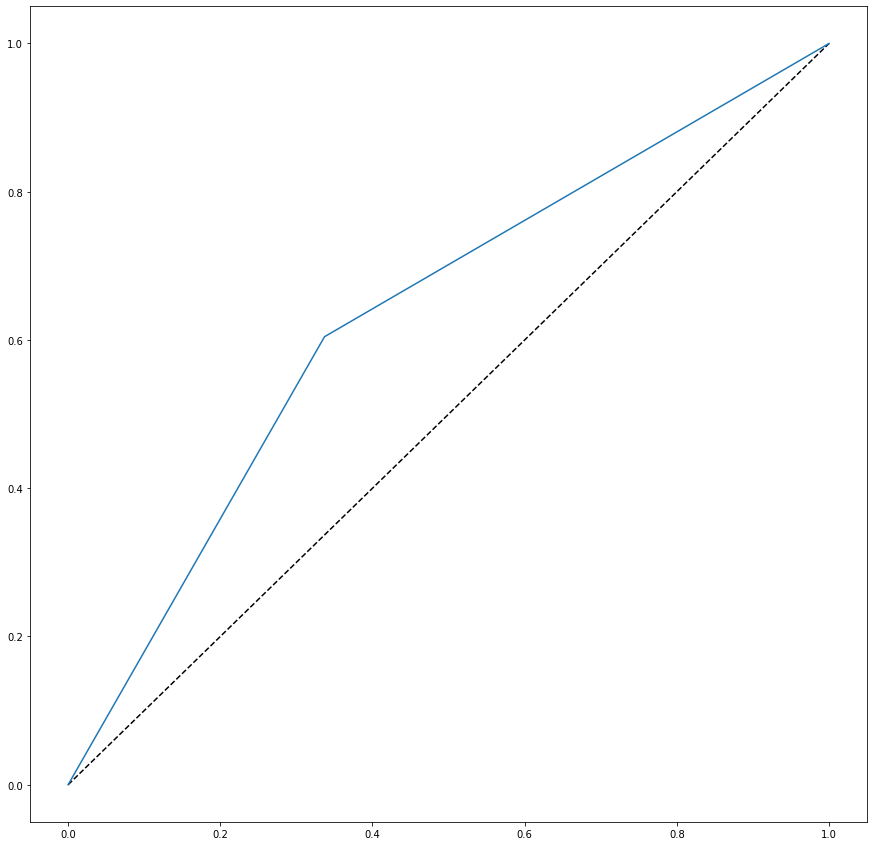

In [196]:
RF = RandomForestClassifier(n_estimators=5000,max_samples=50,random_state=42,max_features=None,n_jobs = -1)
RF.fit(X_train,y_train)
y_pred = RF.predict(X_test)

many_Metrics(y_test,y_pred)

<font size=5> 3. NaN column kept then split training dataset into two 

In [197]:
pd.options.mode.chained_assignment = None  # default='warn'

train_input = pd.read_csv("train_inputs.csv", header=0).rename(columns=input_header)
train_output = pd.read_csv("train_output.csv", header=0).rename(columns=output_header)

# Extraction des lignes contenant de classe 0 et de classe
train_df = pd.merge(train_input, train_output, on='id', how='inner')
df0 = train_df[train_df["result"]==0]
df1 = train_df[train_df["result"]==1]

#Enlevons les nuls et calculons les moyennes et STD
df0_withoutany = df0.dropna() 
mu0 = df0_withoutany["capuchon_insertion"].mean()
sigma0 = df0_withoutany["capuchon_insertion"].std()

df1_withoutany = df1.dropna() 
mu1 = df1_withoutany["capuchon_insertion"].mean()
sigma1 = df1_withoutany["capuchon_insertion"].std()

# On a obtenu les moyennes et écarts-type de nos distrubutions de données. Maintenant remplaçons les NaN. On fait l'hypothèse que les valeurs sont distribuées selon des lois normales.
df0_NA = df0[df0["capuchon_insertion"].isna()]

idx = df0_NA.index[df0_NA['result']==0].tolist()
for i in idx: 
  df0_NA.loc[i,'capuchon_insertion'] = sigma0*np.random.randn() + mu0


df1_NA = df1[df1["capuchon_insertion"].isna()]

idx = df1_NA.index[df1_NA['result']==1].tolist()
for i in idx: 
  df1_NA.loc[i,'capuchon_insertion'] = sigma1*np.random.randn() + mu1

# Maintenant concaténons nos dataframe
DF = pd.concat([df0_NA, df1_NA,df0_withoutany,df1_withoutany], axis=0)

train_input = DF.loc[:, DF.columns != 'result']
train_input = train_input[train_input.columns[~train_input.columns.isin(["id"])]] 
train_output = DF['result']
X_train, X_test, y_train, y_test = train_test_split(train_input, train_output, test_size = 0.3, random_state = 123)

a) SMOTE (Oversampling)

In [198]:
oversample = imb.over_sampling.SMOTE()
X_SMOTE, y_SMOTE = oversample.fit_resample(X_train,y_train)

Confusion Matrix: [[8176 2086]
 [  48   45]]
Surface under the ROC AUC Curve: 0.6402983760947057
Accuracy: 0.7939159826170932
Precision: 0.7967257844474761
Recall: 0.4838709677419355


0.6402983760947057

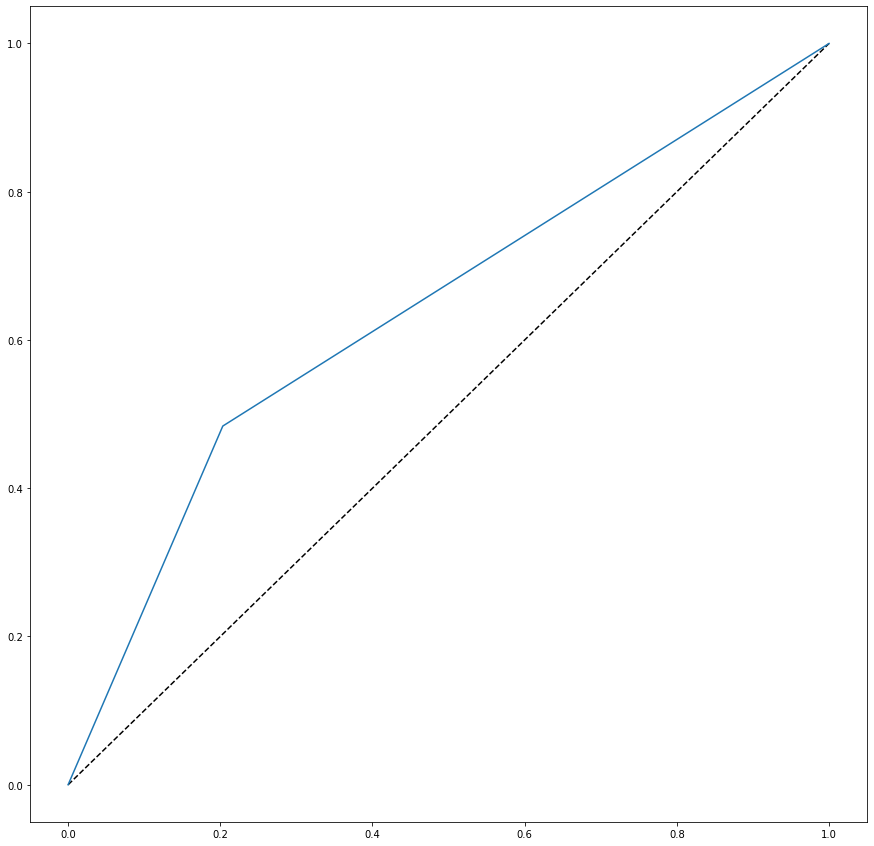

In [199]:
RF = RandomForestClassifier(n_estimators=3000,max_samples=65,max_features=None,random_state=42,n_jobs = -1,oob_score=True)
RF.fit(X_SMOTE,y_SMOTE)
y_pred = RF.predict(X_test)

many_Metrics(y_test,y_pred)

On obtient des scores pouvant atteindre 0.64 pour l'air sous la courbe ROC

b) BALANCING THE CLASS BY REMOVING RANDOM INDIVIDUALS

In [200]:
undersample = imb.under_sampling.RandomUnderSampler(sampling_strategy='majority')
X_under, y_under = undersample.fit_resample(X_train,y_train)

counter = Counter(y_under)
print(counter)

Counter({0: 212, 1: 212})


Confusion Matrix: [[6618 3644]
 [  36   57]]
Surface under the ROC AUC Curve: 0.628903376691961
Accuracy: 0.6446161274746499
Precision: 0.6449035275774703
Recall: 0.6129032258064516


0.628903376691961

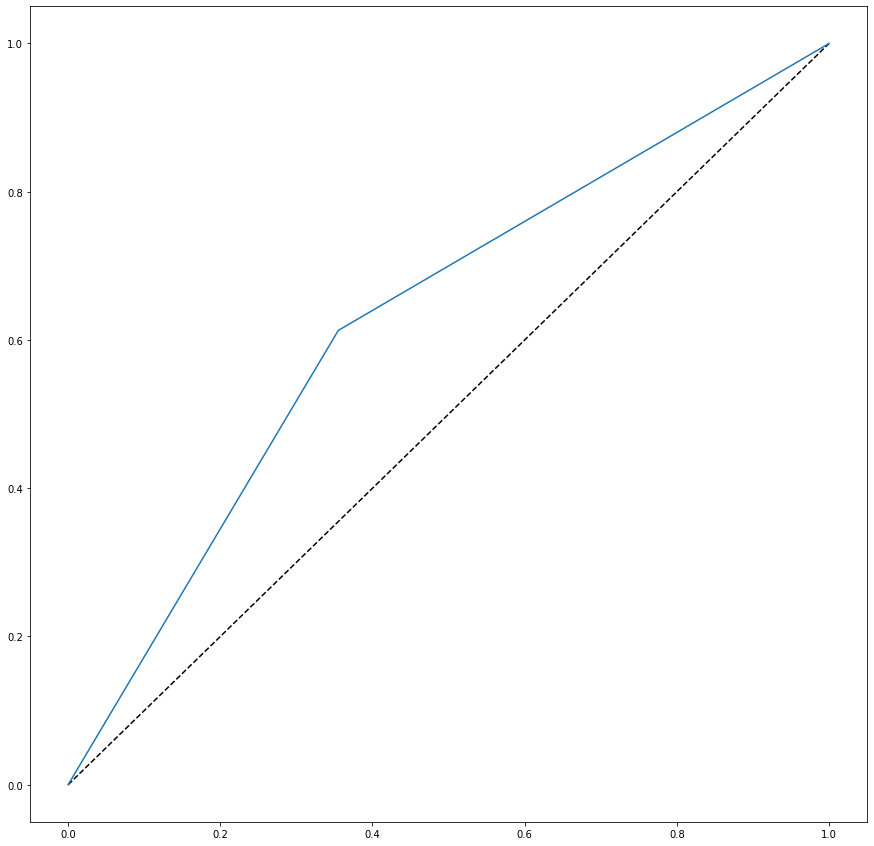

In [201]:
RF = RandomForestClassifier(n_estimators=3000,max_samples=60,max_features=None,random_state=42,n_jobs = -1,oob_score=True)
RF.fit(X_under,y_under)
y_pred = RF.predict(X_test)

many_Metrics(y_test,y_pred)